# Covid-19 Forecasting - LSTM

Neste último notebook vamos tentar utilizar os países semelhantes a Portugal para prever os novos casos confirmados por milhão, assim como os novos óbitos por milhão, também iremos prever a tendência de 1 semana para os confirmados e de 2 semanas para os obitos. Neste caso vamos utilizar uma LSTM para tentar obter os resultados pretendidos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
kaggle_data_path = "../input/aa2-covid-19-parte-iii"

dataset = pd.read_csv( kaggle_data_path + "/portugal_group_dataset.csv")
dataset = dataset.drop(['Unnamed: 0'], axis = 1)

## Time Shifting

Agora como vamos usar redes LSTM podemos definir que para prever os nossos targets utilizemos mais dias do que o dia anterior.

In [3]:
#Coloca o dataset colocado no argumento no formato indicado para alimentar a LSTM com os valores de dias anteriores.
def time_shift(dataset, step):

    x = []
    y = []

    for day in range(len(dataset)):

        if((day + step + 1) > len(dataset)):
            break

        x.append(dataset[day: (day + step)])
        y.append(dataset[day + step][0:4])

    return np.asarray(x),np.asarray(y).reshape(len(y),-1)

In [4]:
# Cálculo de tendências
def trend_calc(data, step, column):
    trend_column = column + "_trend_" + str(step+1)
    data[trend_column] = (data[column].shift(0, fill_value=0) - data[column].shift(step, fill_value=0))/data[column].shift(step, fill_value=0)
    return data

Agora teremos de efetuar tratamento de dados em todos os países e separando-os para que possamos ter vários inputs. Este tratamento inclui o cálculo das tendências a prever, normalização e os time shifts.

In [5]:
countries = dataset['location'].unique()
X = {}
Y = {}

for country in countries:
    data = dataset[dataset['location'] == country].drop(['location'], axis=1).reset_index(drop=True)
    data = trend_calc(data, 13, 'new_deaths_per_million')
    data = trend_calc(data, 6, 'new_cases_per_million')
    data.replace([np.inf, np.nan], 0, inplace=True)

    mean = data.mean(axis=0)
    std = data.std(axis=0)

    aux = data - mean
    data_normalized = aux / std

    print(data)
    
    x,y=time_shift(data_normalized.to_numpy(), 7)
    
    # X atributos de cada país
    # Y targets de cada país
    X[country] = x
    Y[country] = y

    new_cases_per_million  new_deaths_per_million  \
0                   1.332                   0.000   
1                   3.664                   0.000   
2                   2.776                   0.000   
3                   0.333                   0.000   
4                   3.220                   0.000   
..                    ...                     ...   
95                  2.332                   0.000   
96                  1.443                   0.000   
97                  3.775                   0.111   
98                  3.109                   0.111   
99                  3.331                   0.111   

    new_deaths_per_million_trend_14  new_cases_per_million_trend_7  
0                          0.000000                       0.000000  
1                          0.000000                       0.000000  
2                          0.000000                       0.000000  
3                          0.000000                       0.000000  
4                 

## Splitting the data , 10% test, 10% validation

Embora para os métodos tradicionais tenhamos usado TimeSeriesSplit para este tipo de métodos não vamos conseguir utilizar, muito por falta de tempo para realizar uma otimização do modelo através de cross-validation, por isso vamos apenas partir em percetagens fixas do dataset, apenas para termos uma ideia geral da performance do modelo e da quantidade de overfit.

In [6]:
from sklearn.model_selection import train_test_split

# Função que parte o dataset em treino, teste e validação, com as percetagens pretendidas e agrega 
# todos os datasets nas estruturas correspondestes

def split_data(X,Y,country):
    
    X_val = {}
    X_test = {}

    for key in X.keys():
            
        x_train, x_test, y_train, y_test = train_test_split(X[key], Y[key], test_size=0.2, random_state=42,shuffle=False)

        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42,shuffle=False)

        X[key] = x_train
        Y[key] = y_train
        X_val[key] = x_val
        X_test[key] = x_test
         
        if(key == country):
            real_y_val = y_val
            real_y_test = y_test
            
            print("Dataset shape\n")
            print("Val set have a shape of " + str(x_val.shape))
            print("Val label have a shape of " + str(y_val.shape))
            print("\n")
            print("Test set have a shape of " + str(x_test.shape))
            print("Test label have a shape of " + str(y_test.shape))
        
    return X_val,X_test,real_y_val,real_y_test,X,Y

X_val,X_test,y_val,y_test,X,Y = split_data(X,Y,"Portugal")

Dataset shape

Val set have a shape of (10, 7, 4)
Val label have a shape of (10, 4)


Test set have a shape of (9, 7, 4)
Test label have a shape of (9, 4)


In [7]:
from keras.models import Input,Model, Sequential
from keras.layers import LSTM,Dense,BatchNormalization,concatenate, Dropout
from keras.metrics import RootMeanSquaredError

Using TensorFlow backend.


In [8]:
# function to plot rmse train and validation values
def show_history(history):
    print(history.history.keys())
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

De seguida vamos construir um modelo através da API funcional do Keras. Iremos criar vários inputs, tendo cada um deles um dataset diferente e que corresponde a cada país. A cada input será associado um modelo de LSTM com recurrent dropout e dropout normal. Depois cada modelo será concatenato e fornecerão entradas a uma rede Dense com ativação relu de seguida uma camada de dropout. Por fim, temos uma camada Dense para o output, tendo ela quatro nodos (4 targets), esta camada não terá ativação, como é habitual para problemas de regressão.

In [9]:
def build_model(X,Y,country_to_predict):
    
    model_inputs = []
    models_lstms = []
    
    for key in X.keys():
      
        x = X[key]
            
        input_ = Input(shape=(x.shape[1],x.shape[2]))
        model_inputs.append(input_)
        
        model = LSTM(units = 64, dropout=0.3, recurrent_dropout=0.3)(input_)
        models_lstms.append(model)
        
    concaten = concatenate(models_lstms,axis = -1)
    
    dens = Dense(32,activation="relu")(concaten)
    drop = Dropout(0.3)(dens)
    answer = Dense(4)(drop)
    
    model = Model(model_inputs, answer)
    
    return model

model = build_model(X,Y,"Portugal")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7, 4)]       0                                            
______________________________________________________________________________________________

In [10]:
model.compile(optimizer = "rmsprop", loss = "mse", metrics = [RootMeanSquaredError()])

In [11]:
X_test_list = list(X_test.values())
X_val_list = list(X_val.values())
X_train_list = list(X.values())

print(len(X_train_list),X_train_list[0].shape,Y["Portugal"].shape)

18 (74, 7, 4) (74, 4)


In [12]:
history = model.fit(X_train_list,Y["Portugal"],epochs=75,validation_data=(X_val_list,y_val),verbose=2)

Epoch 1/75
3/3 - 5s - loss: 0.9333 - root_mean_squared_error: 0.9661 - val_loss: 0.3725 - val_root_mean_squared_error: 0.6103
Epoch 2/75
3/3 - 1s - loss: 0.6230 - root_mean_squared_error: 0.7893 - val_loss: 0.4027 - val_root_mean_squared_error: 0.6346
Epoch 3/75
3/3 - 1s - loss: 0.6698 - root_mean_squared_error: 0.8184 - val_loss: 0.4012 - val_root_mean_squared_error: 0.6334
Epoch 4/75
3/3 - 1s - loss: 0.5834 - root_mean_squared_error: 0.7638 - val_loss: 0.5166 - val_root_mean_squared_error: 0.7187
Epoch 5/75
3/3 - 2s - loss: 0.5570 - root_mean_squared_error: 0.7463 - val_loss: 0.5427 - val_root_mean_squared_error: 0.7367
Epoch 6/75
3/3 - 1s - loss: 0.5494 - root_mean_squared_error: 0.7412 - val_loss: 0.5052 - val_root_mean_squared_error: 0.7108
Epoch 7/75
3/3 - 1s - loss: 0.5609 - root_mean_squared_error: 0.7489 - val_loss: 0.5894 - val_root_mean_squared_error: 0.7677
Epoch 8/75
3/3 - 1s - loss: 0.5039 - root_mean_squared_error: 0.7099 - val_loss: 0.7305 - val_root_mean_squared_error:

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


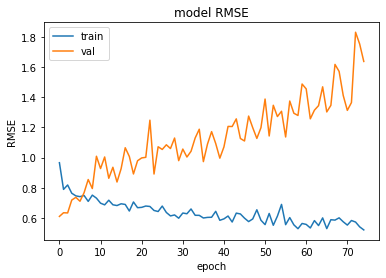

In [13]:
show_history(history)

In [14]:
model.evaluate(X_test_list, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.6914 - root_mean_squared_error: 0.8315


[0.6913729906082153, 0.8314884305000305]

In [15]:
predictions = model.predict(X_test_list)

In [16]:
def bar_plot(index, title):
    x1_draw = y_test[:,index] * std[index] + mean[index]
    x2_draw = predictions[:,index] * std[index] + mean[index]
    r = pd.DataFrame({'Real':x1_draw, 'Predicted': x2_draw})
    r.plot(kind='bar',figsize=(20,5), title='Predictions for ' + title)
    plt.show()

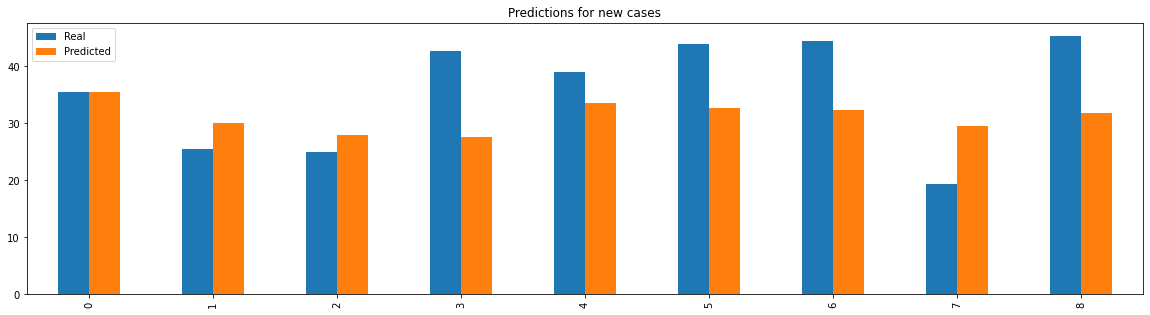

In [17]:
bar_plot(0, 'new cases')

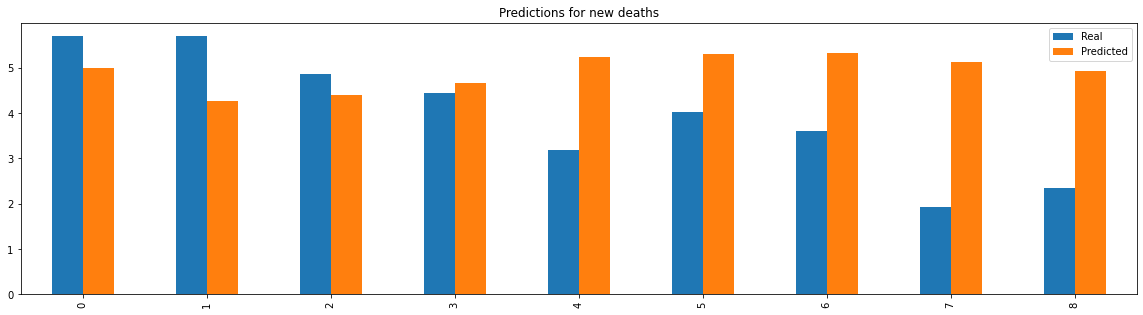

In [18]:
bar_plot(1, 'new deaths')

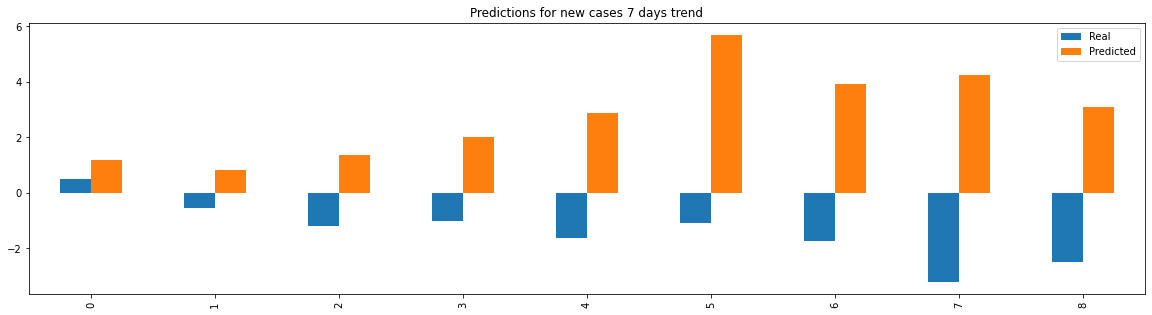

In [19]:
bar_plot(2, 'new cases 7 days trend')

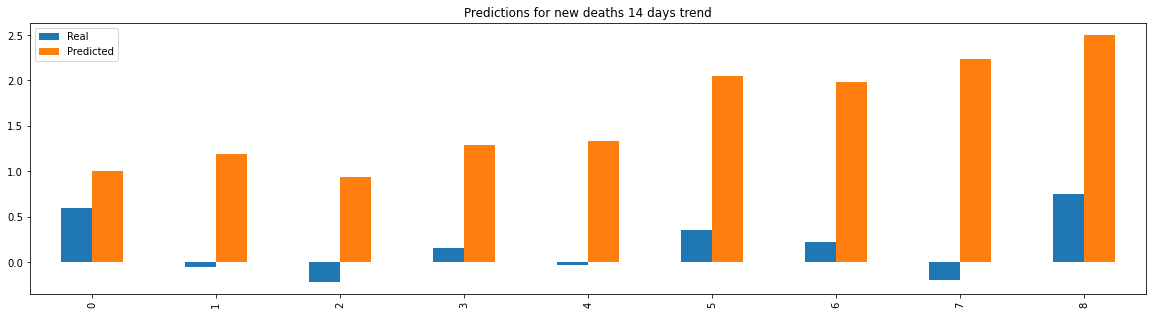

In [20]:
bar_plot(3, 'new deaths 14 days trend')